In [ ]:
import torch
from torch import tensor
from torch.nn import CrossEntropyLoss

## Background

I've recently been training models on the fastai [Imagenette dataset](https://github.com/fastai/imagenette?tab=readme-ov-file) to gain some intuition on what improves downstream performance (accuracy). [My latest experiment](https://vishalbakshi.github.io/blog/posts/2025-06-18-imagenette/) was to train three models on different batch sizes and learning rates (for a fixed 5 epochs) to understand the relationship between the two.

I posted my initial musing (after I had analyzed results for batch sizes 32 to 2048) that lowering the batch size might continue to yield higher accuracy. Jeremy validated this approach:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">That’s a great question! Stable low bs training isn’t easy, but it’s a good plan :)</p>&mdash; Jeremy Howard (@jeremyphoward) <a href="https://twitter.com/jeremyphoward/status/1930486029607416069?ref_src=twsrc%5Etfw">June 5, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

I also prompted Allen AI's [Paper Finder](https://paperfinder.allen.ai/chat/606ffc67-5539-47a9-8c8a-ec5820666ccc?profile=paper-finder-only) with:

> strategies to make low batch size training more stable and improve accuracy for image recognition

Imagenette is unlocking an entire new lane of research and experimentation for me, helping me towards my [TinyScaleLab project goal](https://vishalbakshi.github.io/blog/posts/2025-04-26-TinyScale-Lab-Kickoff/) of training and analyzing high performant tiny language models.

In this blog post, I'll walk through the Gemini Deep Research and Ai2 Paper Finder findings. The full Deep Research report is in [this Google Doc](https://docs.google.com/document/d/1AWoW4sOQ_iR_3pxsTRzYOT0cql60ux0Sjrt4rbLilZM/edit?usp=sharing).

## Gemini's Deep Research Report

Here was my initial prompt:

> I recently have been training xresnet18, xresnet34 and xse_resnext50 on the Imagenette dataset by fast.ai (which is a 10k subset of ImageNet with 10 easily classified classes). I have trained on batch sizes from 1 to 2048. Generally speaking, the highest accuracy achieved increases from a batch size of 1 to a batch size of 8, 16 or 32 (depending on the model/learning rate) and then decreases as batch size increases to 2048. This makes me want to explore small batch size training for this project. Jeremy Howard tweeted that "Stable low bs training isn’t easy, but it’s a good plan". I want you to help me answer two questions in this chat:
>
>
> 1. Why is stable low batch size training difficult?
>
> 2. What techniques are there (either in literature/arxiv, blog posts or forums) to make low batch size training stable? I'm most interested in improving the accuracy of low batch size trainings.

I'll paste the entire executive summary it generated, as its a good one (emphasis mine):

> Training deep learning models with small batch sizes presents a unique set of challenges, primarily stemming from high gradient variance during optimization and the inherent limitations of standard Batch Normalization with few samples. However, this training regime also offers the potential for <mark>improved model generalization</mark>. This report investigates the difficulties associated with stable low batch size training and explores techniques to mitigate these issues, with a particular focus on enhancing model accuracy. For architectures like xresnet, overcoming the instability of Batch Normalization with small batches is a critical first step, often addressed by substituting it with alternatives like <mark>Group Normalization</mark>. Stability and accuracy can be further improved through <mark>careful management of learning rates</mark>, including the use of adaptive schedulers and awareness of optimizer-specific phenomena such as the "surge" in optimal learning rates for Adam-family optimizers. <mark>The choice of optimizer itself</mark>, typically between SGD with momentum and adaptive methods like AdamW, also plays a significant role, alongside appropriate <mark>regularization strategies tailored to the small-batch context</mark>.


The report starts by outlining why small batch sizes lead to unstable training. Gradient updates using a small batch size "may not accurately reflect the gradient of the true loss function that would be computed over the entire dataset" and "is an estimate derived from a very limited subset of the training data".

## Small Batch Sizes: The Double Edged Sword

On one hand, small batch size for a fixed number epochs provide more gradient updates and thus lower the loss. In the plot below (xresnet18) the ideal batch size (16-32) performs better than larger batch sizes. On the other hand, the larger number of updates will take longer and the GPU will be less utilized.

**xresnet18**

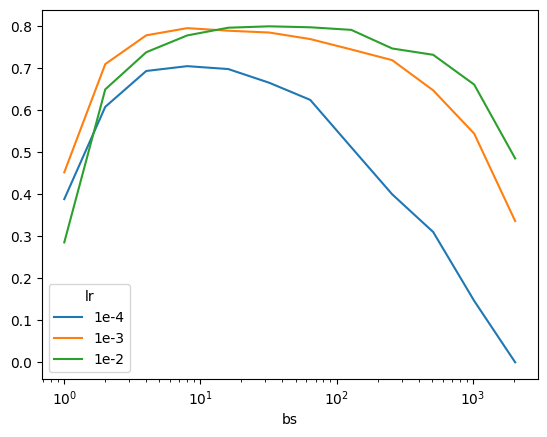

<blockquote class="twitter-tweet" data-dnt="true" align="center" data-conversation="none"><p lang="en" dir="ltr">We covered this in some of our earlier courses - lower batch sizes provide more updates, which should give better results for a fixed # epochs.</p>&mdash; Jeremy Howard (@jeremyphoward) <a href="https://twitter.com/jeremyphoward/status/1927192030335132090?ref_src=twsrc%5Etfw">May 27, 2025</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Additionally, as the Gemini report goes on to say:

> Small batches can lead to gradients that are "bigger and chaotic" because an incorrect prediction on a single data point within a tiny batch can result in a disproportionately large loss and, subsequently, a large gradient update compared to its effect in a larger batch...high gradient noise, stemming from the limited data used for each estimation, leads to more volatile and less precise parameter updates

This was a good opportunity to do a quick refresher on cross entropy loss so I worked through [Chapter 5 of fastbook](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb) again and wrote up [a blog post](https://vishalbakshi.github.io/blog/posts/2025-06-11-CELoss/) and [video walkthrough](https://www.youtube.com/watch?v=swHhoP53jq4) on that.

Suppose we have a batch size of two for a binary classification task:

In [2]:
acts = tensor([[0.4, 9.5], [4, 5]], requires_grad=True)
acts

tensor([[0.4000, 9.5000],
        [4.0000, 5.0000]], requires_grad=True)

With the following targets---the first batch item target is the first class (index `0`), which has a very wrong small activation.





In [5]:
targ = tensor([0, 1])

In [6]:
loss = CrossEntropyLoss()(acts, targ)
loss

tensor(4.7067, grad_fn=<NllLossBackward0>)

In [7]:
loss.backward()
acts.grad

tensor([[-0.4999,  0.4999],
        [ 0.1345, -0.1345]])

Now suppose we had the same two items but in a batch size of 8.

In [8]:
acts = tensor(
    [[ 0.4000,  9.5000], # same item as before
     [ 4.0000,  5.0000], # same item as before
     [ 0.3367,  0.1288],
     [ 0.2345,  0.2303],
     [-1.1229, -0.1863],
     [ 2.2082, -0.6380],
     [ 0.4617,  0.2674],
     [ 0.5349,  0.8094]], requires_grad=True)


Adding 6 items to the targets.

In [9]:
targ = tensor([0, 1, 0, 1, 1, 0, 1, 1])

In [10]:
loss = CrossEntropyLoss()(acts, targ)
loss

tensor(1.5563, grad_fn=<NllLossBackward0>)

Note that the loss is smaller.

In [11]:
loss.backward()
acts.grad

tensor([[-0.1250,  0.1250],
        [ 0.0336, -0.0336],
        [-0.0560,  0.0560],
        [ 0.0626, -0.0626],
        [ 0.0352, -0.0352],
        [-0.0069,  0.0069],
        [ 0.0686, -0.0686],
        [ 0.0540, -0.0540]])

The loss and gradients are much smaller. The impact of the one confidently wrong prediction has decreased with larger batch size.

There are also two other factors at play, as the Gemini report states:

> On one hand, the noisy gradients can cause the optimization process to oscillate significantly around an optimal solution, making it challenging for the model to settle into a good minimum and potentially slowing down overall convergence

> On the other hand, this very noise and the resultant exploratory behavior can be beneficial. The stochasticity introduced by small batches can act as a form of implicit regularization, helping the model to escape sharp, narrow local minima in the loss landscape and instead find flatter, broader minima

The push and pull between the pros (faster updates, implicit regularization) and cons (longer training time, GPU underutilization, oscillating around minima, chaotic gradients/high gradient noise) makes small batch training a fascinating topic. The very characteristics that provide benefit to the training process also damage it.

## Small Batch Size and Batch Normalization

In addition to making the gradient noisy, small batch sizes make Batch Normalization statistics noisy.

> BN standardizes the activations within a network by calculating mean and variance statistics per batch. When batch sizes are very small (e.g., 1, 2, or 4 samples), these batch-wise statistics become extremely noisy and unreliable estimators of the true population statistics across the entire dataset

From the [Group Normalization paper](https://arxiv.org/abs/1803.08494) (for which I have done a [video walkthrough](https://www.youtube.com/watch?v=ZCTcxNEGens)):

> normalizing along the batch dimension
introduces problems — BN’s error increases rapidly when
the batch size becomes smaller, caused by inaccurate batch
statistics estimation.

The three models I'm using all have a considerable number of Batch Normalization layers.

In [12]:
from fastai.vision.all import *

In [13]:
bn_count = 0
for module in xresnet18().modules():
  if isinstance(module, nn.BatchNorm2d): bn_count += 1
bn_count

22

In [14]:
bn_count = 0
for module in xresnet34().modules():
  if isinstance(module, nn.BatchNorm2d): bn_count += 1
bn_count

38

In [15]:
bn_count = 0
for module in xse_resnext50().modules():
  if isinstance(module, nn.BatchNorm2d): bn_count += 1
bn_count

55

## Techniques for Stable and Accurate Low Batch Size Training

The fascinating complexity of stable small batch training is summarized in the report with the following:

> Addressing the challenges of small batch training requires a multi-pronged approach, focusing on adapting learning rate strategies, rethinking normalization layers, selecting appropriate optimizers, and employing advanced gradient management and regularization techniques.

### Learning Rate

> for small batches, the high gradient noise often necessitates smaller learning rates to prevent divergence and ensure stability

We can see that there's evidence for that from my [Imagenette experiments](https://vishalbakshi.github.io/blog/posts/2025-06-18-imagenette/). For the xresnet18, xresnet34 and xse_resnext50 models (top to bottom charts, respectively), 1e-3 yields higher accuracy for lower batch sizes than 1e-2.

**xresnet18**

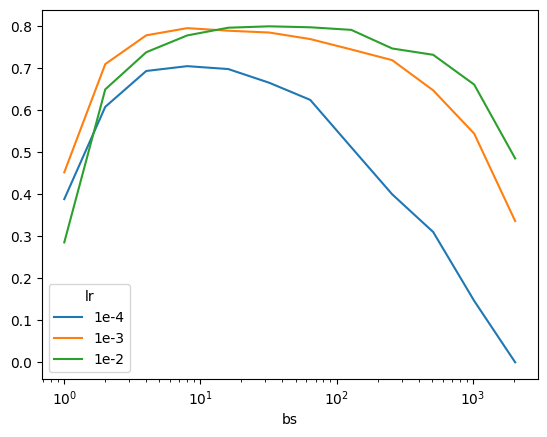

**xresnet34**

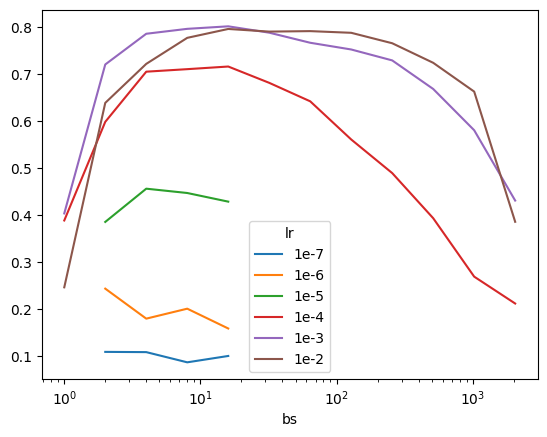

**xse_resnext50**

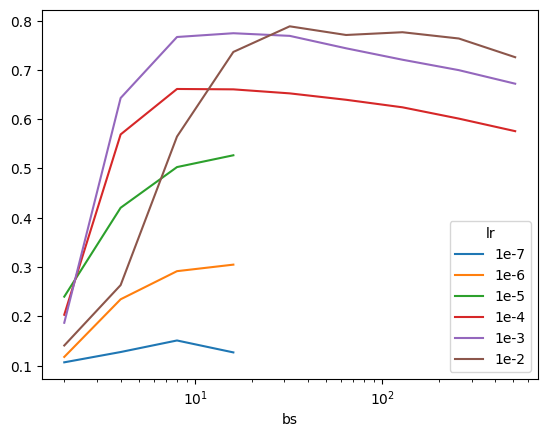

> small batch sizes (e.g., 2 to 32) can be more robust to learning rate choices

I witnessed the second point during my training runs as well. For xresnet34 and a batch size of 8 or 16, the difference in accuracy between learning rates of 1e-4, 1e-3 and 1e-2 was 10%. For a batch size of 1024, the difference in accuracy was 40%. xresnet18 had a similar trend while xse_resnext50 was more robust to changes in learning rates (1e-4, 1e-3, 1e-2) as the accuracy varied about 10-20% across batch sizes of 2 to 1024. In the charts above, this is visualized by the diverging LR curves as batch size increases.

> A learning rate warm-up strategy, where training begins with a very small learning rate that is gradually increased to its target value over a few initial epochs, can significantly stabilize the early phases of training.

My training runs already did this by default (using fastai's `Learner` and `vision_learner`), though I haven't experimented with any available parameters related to this (e.g. number of warmup steps).

> The optimal learning rate strategy is non-linear, optimizer-dependent, and may require empirical tuning guided by these more nuanced theoretical understandings.

### Alternative Forms of Normalization

Gemini found in its research that alternative forms of normalization (other than Batch Normalization) can improve small batch size performance. Most notably, in the Group Normalization paper they found that Group Normalization resulted in a 10% lower error rate than Batch Normalization for small batch sizes. Group Normalization calculates mean and variance for a group of channels for a single image, thereby being _batch independent_, so a small batch size doesn't make the statistics any noisier (as is the case for Batch Normalization where the mean and variance are calculated across all images in the batch). However, there's two sides to this trade-off. As the paper states:

> BN's mean and variance computation introduces uncertainty caused by the stochastic batch sampling, which helps regularization. This uncertainty is missing in GN (and LN/IN). But it is possible that GN combined with a suitable regularizer will improve results. This can be a future research topic.

Gemini also suggests Layer Normalization (calculating mean and variance across all channels for a single image) and Instance Normalization (across a single channel for a single image) as these are both also batch independent. However, the Group Normalization paper finds that these two perform worse than Group Normalization.

### Optimizers and Regularization

Finally, Gemini suggested to try out different optimizers (and tuning their hyperparameters) and regularization techniques (weight decay, data augmentation), both things I wanted to experiment with going into this project.

## Next Steps

Based on Gemini's research and my reading of the Group Normalization paper I plan on experimenting on the following:

- Replace Batch Normalization layers with Group Normalization.
- Add a regularization method like weight decay.
- Try out different optimizers using Benjamin Warner's [optimi](https://optimi.benjaminwarner.dev/) library.
- Try out different data augmentation techniques from Benjamin Warner's [fastxtend](https://fastxtend.benjaminwarner.dev/vision.augment.batch.html) library.

At each step, I use `lr_find` and sample three stable LRs, and focus on small batch sizes of {2, 4, 8, 16, 32, 64}. I'm particularly interested in seeing how these experiments affect the three models I'm using (xresnet18, xresnet34, xse_resnext50) as xse_resnext50 was more robust to larger LRs than the other two.

I'll be documenting my findings in blog posts as well as on my [YouTube channel](https://www.youtube.com/@vishal_learner) so please subscribe to follow along!